## Análise dos Salários da Unidade de San Francisco  

**Contexto:**  
Nesse projeto, tive a oportunidade de apresentar minha expertise ao CEO da **Hidden Analysis**, que me propôs extrair insights da Agência de San Francisco. Ele deixou claro que precisava desse projeto até amanhã de manhã. Caso eu me sinta pressionado, ele sugeriu que posso convocar um analista do RH para ajudar.  

### Exigências dele:  

1. Qual foi a evolução do salário médio ao longo dos anos (TotalPay e TotalPayBenefits).  
2. Quantos funcionários tivemos ao longo dos anos.  
3. Qual foi a maior média salarial registrada e em que ano isso ocorreu, com base no cargo?  
4. Qual foi a evolução do total gasto com salário ao longo dos anos (TotalPayBenefits).  
5. Prever, nesse ritmo, a evolução dos salários médios nos próximos 5 anos.  

--- 


Importando a base e entendimento do desafio inicial

- Para extrair minha base com os salarios vou usar a integração de Python com sql e transforma em um DataFramer ai sim começa a limpesa.

In [1]:
import pyodbc
import pandas as pd

import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from matplotlib.ticker import FuncFormatter

#paleta de cores
cores = plt.get_cmap('Pastel2').colors
ciclo_cores = cycler('color', cores)
plt.rc('axes', prop_cycle=ciclo_cores)

In [2]:
#CONEXAO
bancoDados = ("Driver={SQLite3 ODBC Driver};Server=localhost;Database=./salarios.sqlite")
conexao = pyodbc.connect(bancoDados)
cursor = conexao.cursor()

comando = """ 
SELECT * FROM Salaries
"""
cursor.execute(comando)
valores = cursor.fetchall()

descricao = cursor.description
descricao[0]

('Id', int, None, 10, 10, 0, True)

- Notei que o retorno do primeiro item foi uma tupla e seu primeiro valor e o nome da coluna.

In [3]:
colunas = [tupla[0] for tupla in descricao]#criando uma lista de colunas

tabela = pd.DataFrame.from_records(valores, columns= colunas)
tabela.to_csv('tabela_salarios.csv',index=False)#salvar tabela em .csv

display(tabela.head())
cursor.close()
conexao.close()


,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,,San Francisco,
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,,San Francisco,
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,,San Francisco,
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,,San Francisco,
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,,San Francisco,


### Inicio da Análise de Dados

- Preciso lembrar que essa análise é direcionada para Agência de São Francisco.
- Então desdo inicio tenho que filtrar minha analise só valores da coluna Agency for igual 'San Francisco'.

In [4]:
# O argumento 'low_memory = False' é usado para evitar o consumo excessivo de memória para arquivos grandes
tabela_salarios = pd.read_csv('tabela_salarios.csv',low_memory=False).loc[tabela['Agency'] == 'San Francisco', :]
display(tabela_salarios.head())

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
0,1,NATHANIEL FORD,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,167411.18,0.00,400184.25,NaN,567595.43,567595.43,2011,NaN,San Francisco,NaN
1,2,GARY JIMENEZ,CAPTAIN III (POLICE DEPARTMENT),155966.02,245131.88,137811.38,NaN,538909.28,538909.28,2011,NaN,San Francisco,NaN
2,3,ALBERT PARDINI,CAPTAIN III (POLICE DEPARTMENT),212739.13,106088.18,16452.60,NaN,335279.91,335279.91,2011,NaN,San Francisco,NaN
3,4,CHRISTOPHER CHONG,WIRE ROPE CABLE MAINTENANCE MECHANIC,77916.00,56120.71,198306.90,NaN,332343.61,332343.61,2011,NaN,San Francisco,NaN
4,5,PATRICK GARDNER,"DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)",134401.60,9737.00,182234.59,NaN,326373.19,326373.19,2011,NaN,San Francisco,NaN


Tabela que mostra valores *Nulos*

In [5]:
tabela_nan = tabela_salarios.isnull().groupby('Id')[tabela_salarios.columns].sum()
display(tabela_nan)

,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Notes,Agency,Status
Id,,,,,,,,,,,,,
False,0,0,0,609,4,4,36163,0,0,0,148654,0,110535


Notei que existe varios NaN nesta tabela como que o foco inicial sera na coluna **TotalPay , TotalPayBenefits, Year e Id** e todos eles estão totalmente preenchidos não irei limpar essa tabela ainda quero usar esses valores brutos

In [6]:
def formatacao(valor):
    return 'R${:_.2f}'.format(valor).replace('.',',').replace('_','.')

##### 1. Qual foi a evolução do salário médio ao longo dos anos


,TotalPay,TotalPayBenefits
Year,,
2011,"R$71.744,10","R$71.744,10"
2012,"R$74.113,26","R$100.553,23"
2013,"R$77.611,44","R$101.440,52"
2014,"R$75.463,92","R$100.250,92"


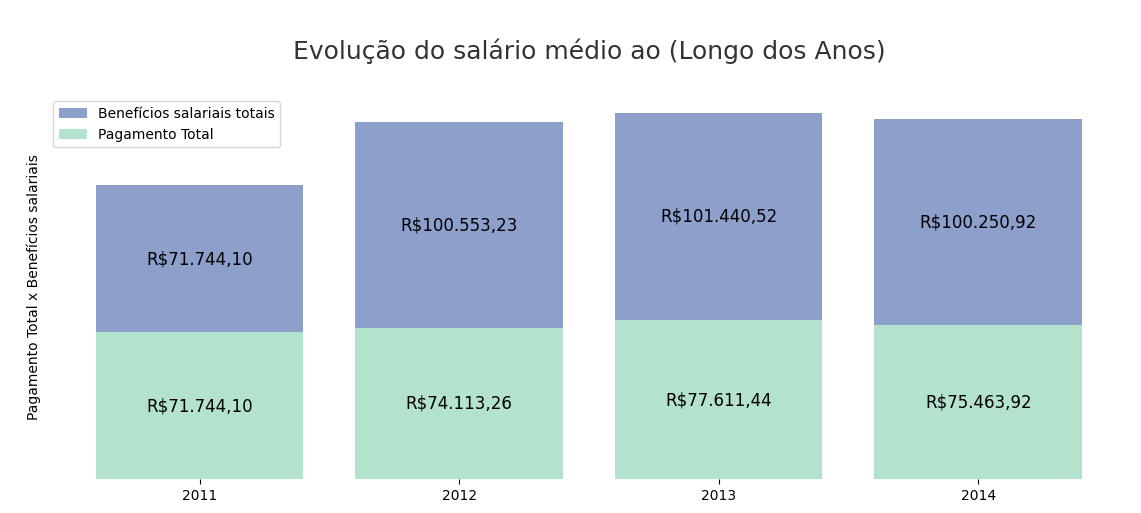

In [7]:
tabela_media = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].mean()

year = tabela_media.index.values
pagamento_total = tabela_media['TotalPay'].values
beneficios_salariais_totais = tabela_media['TotalPayBenefits'].values

paletas = plt.get_cmap('Set2').colors# pegar paleta de cor nova
fig, ax = plt.subplots(figsize=(14,5))

# Barras de benefícios salariais totais (empilhadas)
barras_beneficios = ax.bar(year,beneficios_salariais_totais,label = 'Benefícios salariais totais',bottom = pagamento_total,color  = paletas[2])
plt.bar_label(barras_beneficios,
              labels=[formatacao(v) for v in beneficios_salariais_totais],
              label_type='center',
              fontsize=12,
              color='black')

# Barras de pagamento total
barras_pagamento = ax.bar(year,pagamento_total,label='Pagamento Total')
plt.bar_label(barras_pagamento,
              labels=[formatacao(v) for v in pagamento_total],
              label_type='center',
              fontsize=12,
              color='black')



ax.set_title('\nEvolução do salário médio ao (Longo dos Anos)\n',fontsize=18,alpha=0.8)
ax.set_ylabel('\nPagamento Total x Benefícios salariais')
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])
ax.legend()
ax.set_frame_on(False)

# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_media['TotalPay'] = tabela_media['TotalPay'].apply(formatacao)
tabela_media['TotalPayBenefits'] = tabela_media['TotalPayBenefits'].apply(formatacao)
display(tabela_media)

plt.show()

# EXPLICAR O GRAFICO

##### 2. Quantos funcionários tivemos ao longo dos anos

,Funcionarios
Year,
2011,"36,159"
2012,"36,766"
2013,"37,606"
2014,"38,123"


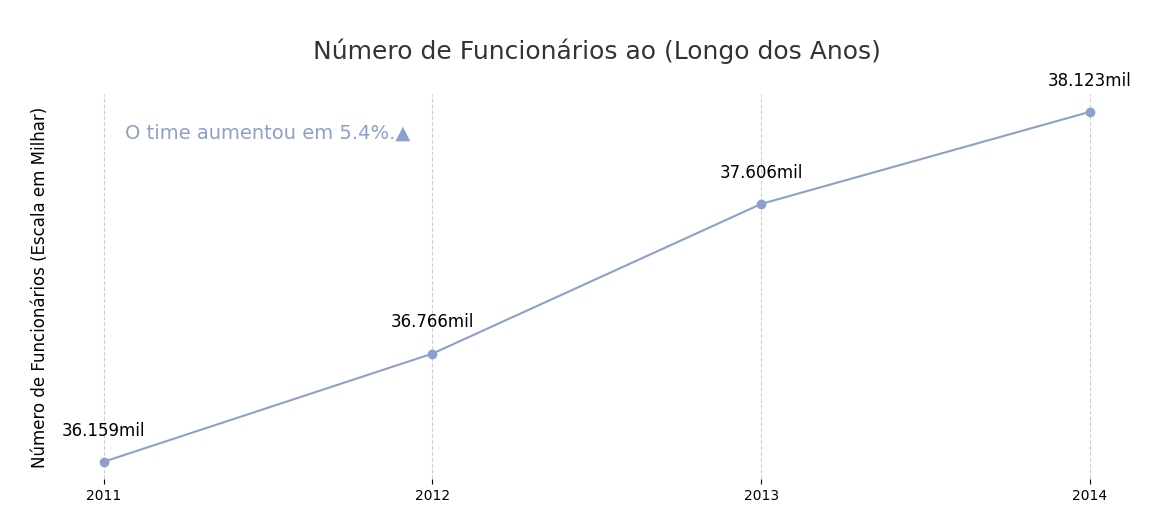

In [ ]:
tabela_funcionarios = tabela.groupby('Year')[['Id']].count()
tabela_funcionarios = tabela_funcionarios.rename(columns={'Id':'Funcionarios'})
funcionarios = tabela_funcionarios['Funcionarios'].values

# Calculando o valor 
crescimento = (funcionarios[-1] - funcionarios[0]) / funcionarios[0]

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(year, funcionarios, marker='o', color=paletas[2], label="Funcionários")

# Adicionando rótulos diretamente nos pontos
for x, y in zip(year, funcionarios):
    ax.text(x, y + 150, f"{y:,}mil".replace(',','.'), ha='center', fontsize=12,color='black')

# Configurações do grafico
ax.set_title("\nNúmero de Funcionários ao (Longo dos Anos)\n", fontsize=18,alpha=0.8)

# Dividi os valores de x com year[len(year)//4] - 0.5
# Ajustei a altura de y com max(funcionarios) - 150

ax.text(year[len(year)//4] - 0.5, max(funcionarios) - 150,"O time aumentou em {:.1%}.▲".format(crescimento),fontsize=14,color=paletas[2],ha='center')
ax.set_ylabel("\nNúmero de Funcionários (Escala em Milhar)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])

# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_funcionarios['Funcionarios'] = tabela_funcionarios['Funcionarios'].apply('{:,.0f}'.format)

display(tabela_funcionarios)

plt.show()


# EXPLICAR O GRAFICO

Os funcionarios cresceao 

##### 3. Qual foi a maior média salarial registrada e em que ano isso ocorreu, com base no cargo?

,Ano,CargoTotalPay,MaiorMediaTP,CargoTotalPayBenefits,MaiorMediaTPB
0,2011,GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,"R$399.211,28",GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY,"R$399.211,28"
1,2012,Chief of Police,"R$321.552,11",Chief of Police,"R$391.362,30"
2,2013,Chief of Police,"R$339.282,07",Chief of Police,"R$425.815,28"
3,2014,Chief Investment Officer,"R$339.653,70",Chief Investment Officer,"R$436.224,36"


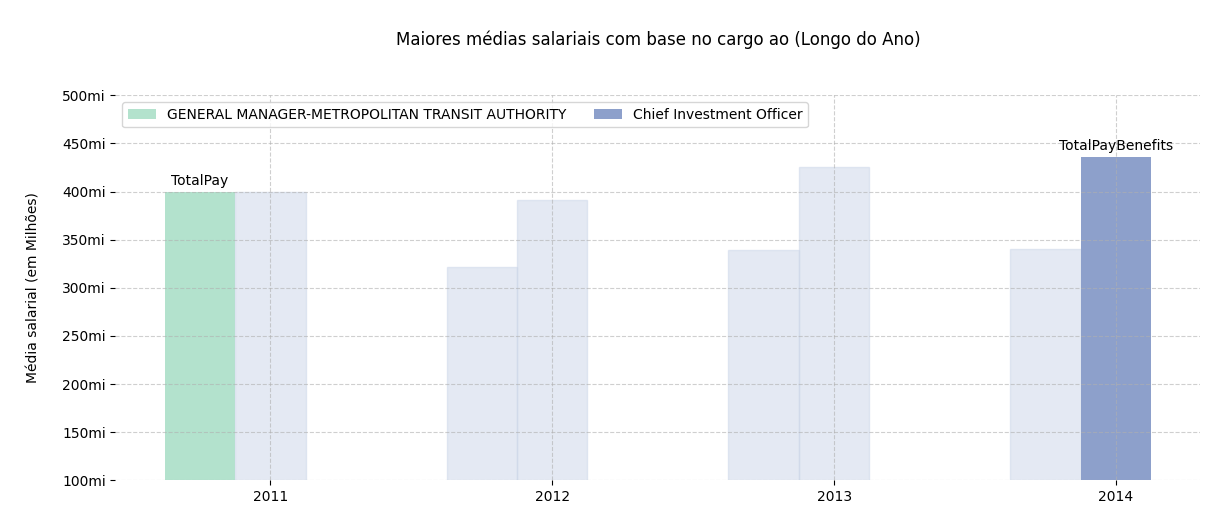

In [ ]:
# Copia a tabela original para não alterar os dados originais.
tabela_maior_media = tabela.copy()

# Inicializa uma lista para armazenar os resultados calculados para cada ano.
tupla_armazenar = []

# Loop para processar cada ano único na tabela.
for coluna in tabela_maior_media['Year'].unique():
    # Filtra a tabela para incluir apenas os dados do ano atual.
    tabela_anos = tabela_maior_media[tabela_maior_media['Year'] == coluna]
    
    # Agrupa os dados por cargo ('JobTitle') e calcula a média de 'TotalPay' e 'TotalPayBenefits'.
    tabela_anos = tabela_anos.groupby('JobTitle')[['TotalPay', 'TotalPayBenefits']].mean()

    # Identifica o cargo com maior média de 'TotalPay' e 'TotalPayBenefits' e seus valores.
    tupla_armazenar.append((
        coluna,                                  # Ano
        tabela_anos['TotalPay'].idxmax(),       # Cargo com maior média em TotalPay
        tabela_anos['TotalPay'].max(),          # Maior média em TotalPay
        tabela_anos['TotalPayBenefits'].idxmax(),  # Cargo com maior média em TotalPayBenefits
        tabela_anos['TotalPayBenefits'].max()   # Maior média em TotalPayBenefits
    ))

# Cria um DataFrame a partir da lista armazenada com colunas nomeadas.
tabela_maior_media = pd.DataFrame(
    tupla_armazenar, 
    columns=['Ano', 'CargoTotalPay', 'MaiorMediaTP', 'CargoTotalPayBenefits', 'MaiorMediaTPB']
)

# Extrai as colunas de interesse em arrays separados para uso no gráfico.
pagamento_total = tabela_maior_media['MaiorMediaTP'].values
beneficios_salariais_totais = tabela_maior_media['MaiorMediaTPB'].values
cargos = tabela_maior_media['CargoTotalPay'].values
year = tabela_maior_media['Ano'].values

# Cria um dicionário para armazenar as médias salariais e de benefícios.
penguin_means = {
    'TotalPay': pagamento_total,
    'TotalPayBenefits': beneficios_salariais_totais,
}

x = np.arange(len(year))  # Posições no eixo X
largura = 0.25           # Largura das barras
multiplica = 0           # Multiplicador para calcular o deslocamento das barras

# Rótulos para os maiores valores em cada categoria.
rotulos_pt = [list(penguin_means.keys())[0] if valor == max(pagamento_total) else '' for valor in pagamento_total]
rotulos_tpb = [list(penguin_means.keys())[1] if valor == max(beneficios_salariais_totais) else '' for valor in beneficios_salariais_totais]

fig, ax = plt.subplots(figsize=(14, 5))

# Loop para criar as barras para cada categoria ('TotalPay' e 'TotalPayBenefits').
for chave, valor in penguin_means.items():
    offset = largura * multiplica  # Calcula o deslocamento da barra com base no índice.
    
    if chave == 'TotalPay':
        # Adiciona as barras para 'TotalPay' com uma leve diferença na altura (+150).
        rects = ax.bar(
            x + offset, valor + 150, largura, 
            label=cargos[tabela_maior_media['MaiorMediaTP'].idxmax()]
        )
        ax.bar_label(rects, padding=3, labels=rotulos_pt)  # Adiciona os rótulos nas barras.
        multiplica += 1  # Incrementa o multiplicador.
        
        # Altera a cor e a transparência das barras que não representam o valor máximo.
        for i, bar in enumerate(rects):
            if i != list(pagamento_total).index(max(list(pagamento_total))):
                rects[i].set_color(cores[2])
                rects[i].set_alpha(0.5)

    else:
        # Adiciona as barras para 'TotalPayBenefits' com cor definida.
        rects = ax.bar(
            x + offset, valor, largura, 
            label=cargos[tabela_maior_media['MaiorMediaTPB'].idxmax()],
            color=paletas[2]
        )
        ax.legend(loc='upper left', ncols=2)  # Adiciona a legenda no canto superior esquerdo.
        ax.bar_label(rects, padding=3, labels=rotulos_tpb)  # Adiciona os rótulos nas barras.
        multiplica += 1  # Incrementa o multiplicador.

        # Altera a cor e a transparência das barras que não representam o valor máximo.
        for i, bar in enumerate(rects):
            if i != list(beneficios_salariais_totais).index(max(list(beneficios_salariais_totais))):
                rects[i].set_color(cores[2])
                rects[i].set_alpha(0.5)

# Configurações do gráfico
ax.set_ylabel('\nMédia salarial (em Milhões)\n')  # Rótulo do eixo Y.
ax.set_title("\nMaiores médias salariais com base no cargo ao (Longo dos Anos)\n\n", fontsize=12)  # Título.
ax.set_xticks(x + largura, year)  # Configura os ticks do eixo X.
ax.set_ylim(100_000, 500_000)  # Ajusta os limites do eixo Y.
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)

# Função para formatar os valores do eixo Y.
def format_ticks(value, _):
    return f"{value/1000:.0f}mi"

# Aplica a formatação personalizada ao eixo Y.
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))


# Aplica formatação personalizada às colunas de médias no DataFrame.
tabela_maior_media['MaiorMediaTP'] = tabela_maior_media['MaiorMediaTP'].apply(formatacao)
tabela_maior_media['MaiorMediaTPB'] = tabela_maior_media['MaiorMediaTPB'].apply(formatacao)

display(tabela_maior_media)

plt.show()


##### 4. Qual foi a evolução do total gasto com salário ao longo dos anos

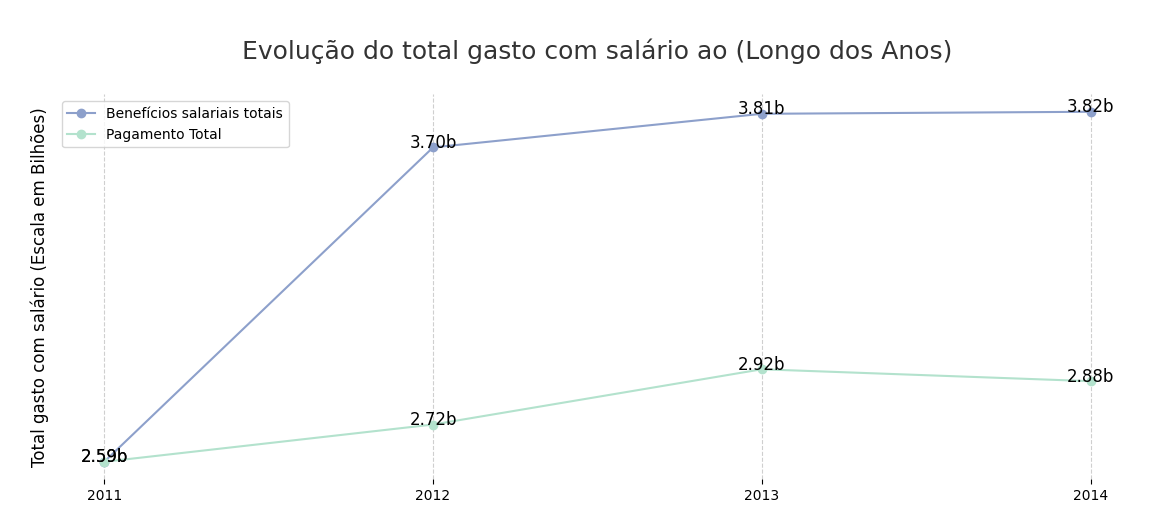

In [10]:
def exibir_grafico_linha(base,altura):
    '''#### Funcao posiciona cada valor em formato de bilhoes<br>
       
        for x, y in zip(base, altura):
        
            valor_bilhoes = y / 1e9
            ax.text(x, y + 300, f"{valor_bilhoes:,.2f}b".replace(',','.'),
            ha='center',
            fontsize=12,color='black')
'''
    for x, y in zip(base, altura):

        valor_bilhoes = y / 1e9
        ax.text(x, y + 150, f"{valor_bilhoes:,.2f}b".replace(',','.'), ha='center', fontsize=12,color='black')


tabela_salario = tabela.groupby('Year')[['TotalPay','TotalPayBenefits']].sum()
pagamento_total = tabela_salario['TotalPay'].values
beneficios_salariais_totais = tabela_salario['TotalPayBenefits'].values


fig, ax = plt.subplots(figsize=(14,5))
ax.plot(year, beneficios_salariais_totais, marker='o', color=paletas[2], label="Benefícios salariais totais")
ax.plot(year, pagamento_total, marker='o', label="Pagamento Total")


# Adicionando rótulos diretamente nos pontos dos graficos de linha
exibir_grafico_linha(year,pagamento_total)
exibir_grafico_linha(year,beneficios_salariais_totais)

# Configurações
ax.set_title("\nEvolução do total gasto com salário ao (Longo dos Anos)\n", fontsize=18,alpha=0.8)

# Dividi os valores de x com year[len(year)//4] - 0.5
# Ajustei a altura de y com max(pagamento_total) - 150

# ax.text(year[len(year)//4] - 0.5, max(pagamento_total) - 150,"O time aumentou em {:.1%}.▲".format(crescimento),fontsize=14,color=paletas[2],ha='center')
ax.set_ylabel("\nTotal gasto com salário (Escala em Bilhões)", fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_frame_on(False)
ax.set_xticks(ticks=year,labels=year)
ax.set_yticks([])
ax.legend()
plt.show()


##### 5. Prever, nesse ritmo, a evolução dos salários médios nos próximos 5 anos. 